# Imports and Utils

In [95]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from scipy.ndimage import convolve, uniform_filter, maximum_filter
from numpy.typing import NDArray

In [96]:
def showImage(img: Image.Image):
    if img.mode == 'L':
        plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    else:
        plt.imshow(img)
    plt.tight_layout()
    plt.axis('off')
    plt.show()


def gaussian_kernel(sigma: float, kernel_size: int) -> NDArray:
    def gaussian(x: float, y: float) -> float:
        return np.exp(-(x**2 + y**2) / (2 * sigma**2))

    kernel = np.zeros((kernel_size, kernel_size))

    for i in range(kernel_size):
        for j in range(kernel_size):
            kernel[i, j] = gaussian(i - kernel_size // 2, j - kernel_size // 2)

    return kernel / kernel.sum()


def gaussian_blur(
    img: Image.Image, sigma: float = 3, kernel_size: int | None = None
) -> Image.Image:
    if img.mode != 'L':
        img = img.convert('L')

    if kernel_size is None:
        kernel_size = int(2 * np.ceil(3 * sigma) + 1)

    kernel = gaussian_kernel(sigma, kernel_size)
    img_array = np.array(img, dtype=np.float64)
    filtered_img_arrary = convolve(img_array, kernel).astype(np.uint8)
    return Image.fromarray(filtered_img_arrary, 'L')


def sobel(img: Image.Image) -> tuple[NDArray, NDArray]:
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    img_array = np.array(
        img, dtype=np.int32
    )  # Convert to int16 to prevent overflow/underflow
    gx: NDArray[np.float64] = convolve(img_array, kernel_x)
    gy: NDArray[np.float64] = convolve(img_array, kernel_y)

    # Normalize to [0, 255] with the same min, max
    g_min: np.float64 = min(gx.min(), gy.min())
    g_max: np.float64 = max(gx.max(), gy.max())

    gx = ((gx - g_min) / (g_max - g_min) * 255).astype(np.uint8)
    gy = ((gy - g_min) / (g_max - g_min) * 255).astype(np.uint8)

    return gx, gy


def get_structure_tensor(
    Ix: NDArray, Iy: NDArray, window_size: int = 3
) -> tuple[NDArray, NDArray, NDArray]:
    """
    Compute the structure tensor (also called second-moment matrix) for an image.
    """
    # convert to float
    Ix = Ix.astype(np.float64)
    Iy = Iy.astype(np.float64)

    # Computing products of derivatives at every pixel
    Ix2 = Ix**2
    Iy2 = Iy**2
    Ixy = Ix * Iy

    # Compute the sums of the products of derivatives at each pixel
    Sx2 = uniform_filter(Ix2, window_size)
    Sy2 = uniform_filter(Iy2, window_size)
    Sxy = uniform_filter(Ixy, window_size)

    return Sx2, Sy2, Sxy


def harris_operator(
    Sx2: NDArray,
    Sy2: NDArray,
    Sxy: NDArray,
    k: float = 0.05,
) -> NDArray:
    """
    Harris operator.
    """
    # Compute determinant and trace of the structure tensor
    detH = Sx2 * Sy2 - Sxy**2
    traceH = Sx2 + Sy2

    # Compute the response R
    R = detH - k * traceH**2
    return R


def harris_corner_detection(
    Ix: NDArray,
    Iy: NDArray,
    window_size: int = 3,
    k: float = 0.05,
    threshold_ratio: float = 0.01,
) -> NDArray:
    """
    Compute the Harris corner response.
    """
    Sx2, Sy2, Sxy = get_structure_tensor(Ix, Iy, window_size)
    R = harris_operator(Sx2, Sy2, Sxy, k)
    threshold = threshold_ratio * R.max()
    R = np.where(R > threshold, R, 0).astype(np.uint8)

    return R


def non_maximum_suppression(R: NDArray, window_size: int = 5) -> NDArray:
    """
    Apply non-maximum suppression to an array.
    """
    local_max = maximum_filter(R, size=window_size)
    R = np.where(R == local_max, R, 0)

    return R


def mark_image(img: Image.Image, R: NDArray, dot_size: int = 3) -> Image.Image:
    """
    Show the original image with corners marked.
    If the image is grayscale, it is converted to RGB to show red corners.
    """
    # Convert image to RGB mode if it's not already
    if img.mode != "RGB":
        img = img.convert("RGB")
    
    img_array = np.array(img)
    
    # Define the offset for the dot size
    offset = dot_size // 2
    
    # Get coordinates of non-zero pixels (i.e., corners)
    y_coords, x_coords = np.where(R > 0)
    
    for y, x in zip(y_coords, x_coords):
        img_array[max(y - offset, 0):min(y + offset + 1, img_array.shape[0]), 
                  max(x - offset, 0):min(x + offset + 1, img_array.shape[1])] = [255, 0, 0]  # RGB value for red

    return Image.fromarray(img_array, mode="RGB")


# Main

## Gaussian Blur

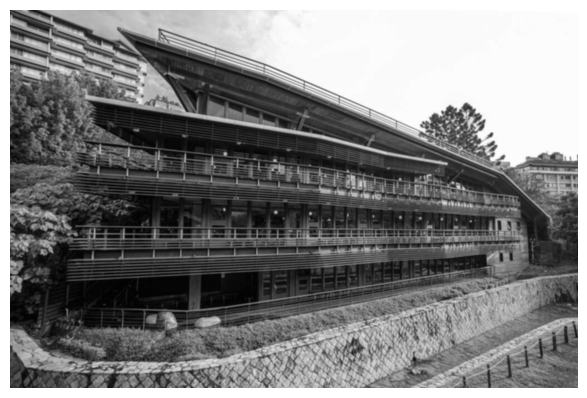

In [97]:
img = Image.open('hw1-2.jpg')

# apply Gaussian blur (also grayscaled)
gaussian_blurred_img = gaussian_blur(img, 3, 3)
showImage(gaussian_blurred_img)

## Sobel Filter

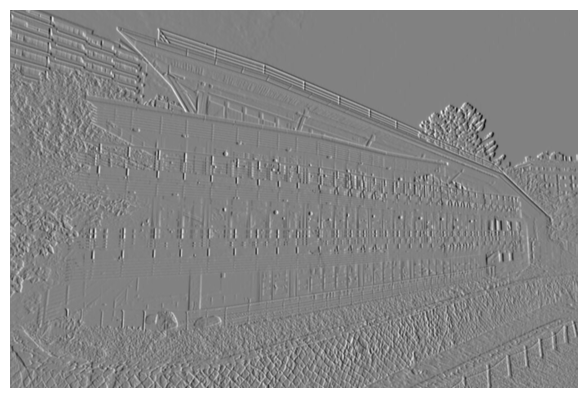

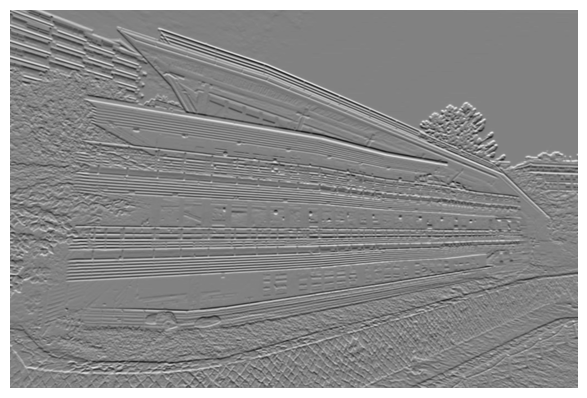

In [98]:
gx, gy = sobel(gaussian_blurred_img)
gx_img = Image.fromarray(gx, 'L')
gy_img = Image.fromarray(gy, 'L')
showImage(gx_img)
showImage(gy_img)

## Harris Corner Detection

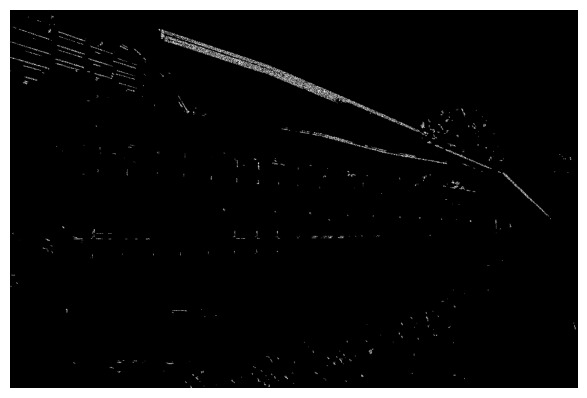

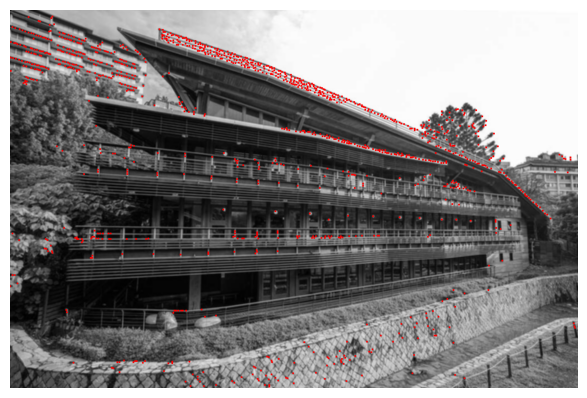

In [112]:
R = harris_corner_detection(
    gx, 
    gy, 
    window_size=5, 
    threshold_ratio=0.01
)
R_threshold_img = Image.fromarray(R, 'L')
showImage(R_threshold_img)

R_nms = non_maximum_suppression(R)
R_nms_img = Image.fromarray(R_nms, 'L')
marked_img = mark_image(gaussian_blurred_img, R_nms, dot_size=5)
showImage(marked_img)